In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c rdkit rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-04-15 12:05:41--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2022-04-15 12:05:41--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ 
The environment is inconsistent, please check

In [ ]:
import numpy as np
import pandas as pd
import tqdm.auto as tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import rdkit, rdkit.Chem.AllChem, rdkit.Chem.Crippen
import rdkit.Chem as Chem
from rdkit.Chem import Draw

import torch
import sklearn.linear_model, sklearn.model_selection

## Introduction to RDKit

RDKit is a collection of cheminformatics and machine-learning software written in C++ and Python that allows you to work with molecules easily.

### Constructing a molecule

In [ ]:
# A molecule can be constructed through multiple approaches

m = Chem.MolFromSmiles('c1ccccc1')

m = Chem.MolFromMolFile('benzene.mol')

stringWithMolData = open('benzene.mol','r').read()
m = Chem.MolFromMolBlock(stringWithMolData)


# All of these functions return a rdkit.Chem.rdchem.Mol object on success
print(type(m))


# All of these functions return None on failure
m = Chem.MolFromSmiles('c1cc')
print(m)

<class 'rdkit.Chem.rdchem.Mol'>
None


### Constructing sets of molecules

In [ ]:
suppl = Chem.SDMolSupplier('biogenic.sdf')
print(suppl[0])

mol = suppl[0]
print(mol.GetPropsAsDict())

{'zinc_id': 'ZINC000001530427', 'smiles': 'C[C@@H]1O[C@@H]1P(=O)(O)O'}


### Exporting/Writing molecules

In [ ]:
m = Chem.MolFromSmiles('c1ccccc1')
print(type(m))

smiles = Chem.MolToSmiles(m)
print(smiles)

# MolToSmiles gives the canonical SMILES, so  the output would be the same regardless of the input
smiles_1 = Chem.MolToSmiles(Chem.MolFromSmiles('C1=CC=CN=C1'))
smiles_2 = Chem.MolToSmiles(Chem.MolFromSmiles('c1cccnc1'))
smiles_3 = Chem.MolToSmiles(Chem.MolFromSmiles('n1ccccc1'))
print(smiles_1, smiles_2, smiles_3)

print()
# If you want to have the Kekule form, then use the kekuleSmiles parameter
smiles = Chem.MolToSmiles(m)
print(smiles)

Chem.Kekulize(m)
smiles = Chem.MolToSmiles(m, kekuleSmiles=True)
print(smiles)


<class 'rdkit.Chem.rdchem.Mol'>
c1ccccc1
c1ccncc1 c1ccncc1 c1ccncc1

c1ccccc1
C1=CC=CC=C1


In [ ]:
# You can also get the mol block of a molecule
m.SetProp("_Name","benzene")
print(Chem.MolToMolBlock(m))



benzene
     RDKit          2D

  6  6  0  0  0  0  0  0  0  0999 V2000
    1.5000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500    1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500    1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  2  0
  2  3  1  0
  3  4  2  0
  4  5  1  0
  5  6  2  0
  6  1  1  0
M  END



In [ ]:
# In order for atom or bond stereochemistry to be recognised correctly by most software, it’s essential that the mol block have atomic coordinates
# It’s also convenient for many reasons, such as drawing the molecules

# Generating a mol block for a molecule that does not have coordinates will, by default, 
# automatically cause coordinates to be generated
# These are not, however, stored with the molecule. 
# We have to use the AllChem module to generate the 3D coordinates

from rdkit.Chem import AllChem

AllChem.Compute2DCoords(m)
# print(Chem.MolToMolBlock(m))

# The Hydrogen atoms are implicit in the molecule, you can add them explicitly through
m1 = Chem.AddHs(m)
# print(Chem.MolToMolBlock(m1))

# You can remove the Hydrogen atoms easily too. You would want to add the Hydrogens if you're computing the 3D coordinates for example
m2 = Chem.RemoveHs(m1)
print(Chem.MolToMolBlock(m2))


benzene
     RDKit          2D

  6  6  0  0  0  0  0  0  0  0999 V2000
    1.5000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500   -1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7500    1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.7500    1.2990    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  2  0
  2  3  1  0
  3  4  2  0
  4  5  1  0
  5  6  2  0
  6  1  1  0
M  END



## Molecule Properties

In [ ]:
mol = Chem.MolFromSmiles('c1ccccc1')
m1 = Chem.AddHs(mol)

print(m1.GetNumAtoms())

12


In [ ]:
# Once you have the molecule, you can loop over its atoms and bonds


for atom in mol.GetAtoms():
  print(atom.GetAtomicNum())

print()

for bond in mol.GetBonds():
  print(bond.GetBondType())

print()

# You can also query individual bonds or atoms
mol.GetAtomWithIdx(0).GetAtomicNum()
mol.GetAtomWithIdx(0).GetExplicitValence()

print()

bond = mol.GetBondWithIdx(0)
print(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

print()

# You can also get the neighbours of a particular atom in a molecule
atom = mol.GetAtomWithIdx(0)
for n_atom in atom.GetNeighbors():
  print(n_atom.GetAtomicNum())

# Atoms and bonds both carry information about the molecule’s rings:
print(mol.GetAtomWithIdx(0).IsInRing())

6
6
6
6
6
6

AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC
AROMATIC


0 1

6
6
True


### Exercise Question

- For "COc1ccc(C=NNC2=NC(=O)C(CC(=O)NC(C)C)S2)cc1", print all the bonds between a carbon and an oxygen atom.

In [ ]:
mol = Chem.MolFromSmiles("COc1ccc(C=NNC2=NC(=O)C(CC(=O)NC(C)C)S2)cc1")

for bond in mol.GetBonds():
  f_atom = mol.GetAtomWithIdx(bond.GetBeginAtomIdx()).GetAtomicNum()
  s_atom = mol.GetAtomWithIdx(bond.GetEndAtomIdx()).GetAtomicNum()

  if f_atom == 6 and s_atom == 8:
    print('C and O')
  elif f_atom == 8 and s_atom == 6:
    print('O and C')

C and O
O and C
C and O
C and O


### Modifying Molecules

In [ ]:
# You can remove or add explicit Hydrogens in the molecule as we saw earlier. This helps when you're trying to optimize the 3D geometry for e.g.

m=Chem.MolFromSmiles('CCO')
print(m.GetNumAtoms())

m2 = Chem.AddHs(m)
print(m2.GetNumAtoms())

m3 = Chem.RemoveHs(m2)
print(m3.GetNumAtoms())


3
9
3


In [ ]:
# Bonds in the aromatic rings of molecules are stored as the aromatic bond type

mol = Chem.MolFromSmiles('c1ccccc1')
print(mol.GetBondWithIdx(0).GetBondType())

# Kekulize the molecule to split up the bonds involved in the aromatic rings to single and double bonds. They are still flagged as aromatic bonds
Chem.Kekulize(mol)
print(mol.GetBondWithIdx(0).GetBondType(), mol.GetBondWithIdx(0).GetIsAromatic())
print(mol.GetBondWithIdx(1).GetBondType(), mol.GetBondWithIdx(1).GetIsAromatic())

AROMATIC
DOUBLE True
SINGLE True


### Displaying Molecules

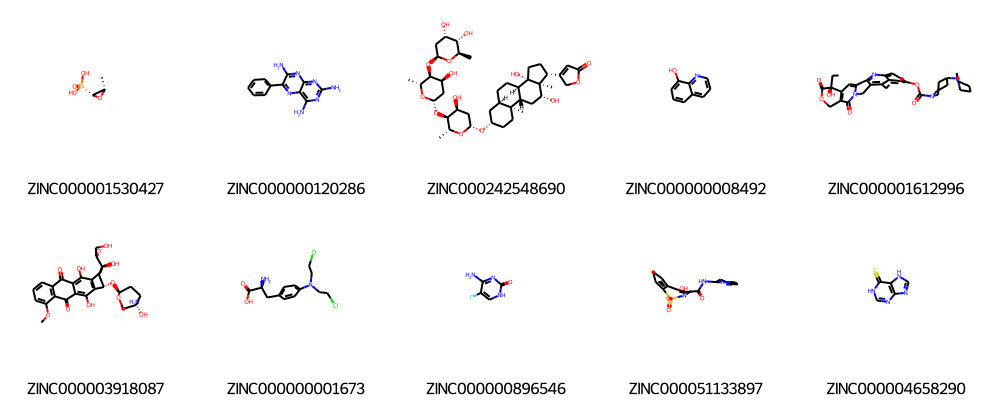

In [ ]:
suppl = Chem.SDMolSupplier('biogenic.sdf')
mols = [x for x in suppl if x is not None]


img = Draw.MolsToGridImage(mols[:10], molsPerRow=5, legends=[x.GetProp('zinc_id') for x in mols[:10]])
display(img)

### Substructure Searching

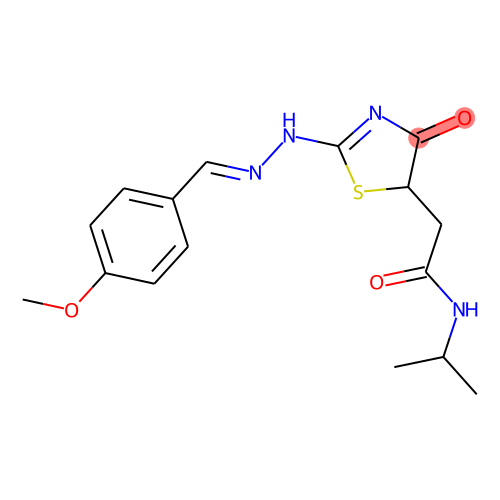

In [ ]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

smi = 'COc1ccc(C=NNC2=NC(=O)C(CC(=O)NC(C)C)S2)cc1'
mol = Chem.MolFromSmiles(smi)

patt = Chem.MolFromSmarts('[CX3]=[OX1]')
hit_ats = list(mol.GetSubstructMatch(patt))

hit_bonds = []
for bond in patt.GetBonds():
    aid1 = hit_ats[bond.GetBeginAtomIdx()]
    aid2 = hit_ats[bond.GetEndAtomIdx()]
    hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())


d = rdMolDraw2D.MolDraw2DSVG(500, 500)
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats,
                                   highlightBonds=hit_bonds)
d.FinishDrawing()
SVG(d.GetDrawingText())

### Exercise

- Find the SMARTS string that represents a ketone, and display the substructure in a molecule of your choice

### Molecular Descriptors

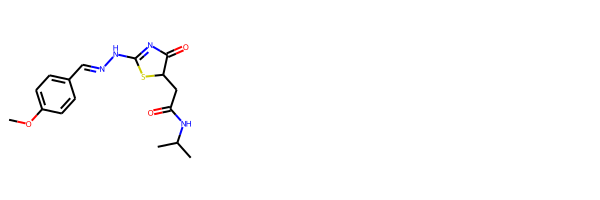

1.5313999999999997 92.15 6


In [ ]:
from rdkit.Chem import Descriptors


m = Chem.MolFromSmiles(r'COc1ccc(C=NNC2=NC(=O)C(CC(=O)NC(C)C)S2)cc1')
img = Draw.MolsToGridImage([m])
display(img)

print(Descriptors.MolLogP(m), Descriptors.TPSA(m), Descriptors.NumRotatableBonds(m))

### Generating 3D Conformers

In [ ]:
m = Chem.MolFromSmiles(r'COc1ccc(C=NNC2=NC(=O)C(CC(=O)NC(C)C)S2)cc1')
m = Chem.AddHs(m) # Add Hs to the molecule before generating the conformers

AllChem.EmbedMolecule(m,randomSeed=0xf00d,useExpTorsionAnglePrefs=True,useBasicKnowledge=True)
print(m.GetNumConformers())

cids = AllChem.EmbedMultipleConfs(m,10,pruneRmsThresh=1.0,randomSeed=0xf00d,
                           useExpTorsionAnglePrefs=True,useBasicKnowledge=True)
print(m.GetNumConformers())

conf = m.GetConformer(cids[0])
print(conf.GetPositions())

1
10
[[ 8.30759386 -2.48782306  2.63119074]
 [ 8.28347386 -2.01791701  1.3112757 ]
 [ 7.06821138 -1.69452553  0.71763379]
 [ 5.90098008 -1.83663342  1.43790229]
 [ 4.71125775 -1.50212868  0.81998788]
 [ 4.69698501 -1.03417938 -0.49120711]
 [ 3.46058201 -0.64026513 -1.14022925]
 [ 2.33711922 -0.6126843  -0.73426461]
 [ 1.43694177 -0.79267931  0.21096867]
 [ 0.06438139 -0.73365944 -0.19733271]
 [-0.45667048 -1.4267537  -1.1041644 ]
 [-1.83599963 -1.21760546 -1.3619546 ]
 [-2.60541484 -2.12041134 -1.90974115]
 [-2.339338    0.0900136  -0.96677513]
 [-3.78475834  0.16098617 -0.56687533]
 [-4.07756061  1.63716564 -0.19551774]
 [-3.07313302  2.20932096  0.2607766 ]
 [-5.33772458  2.116488   -0.41745443]
 [-6.57884444  2.59924615 -0.63312124]
 [-6.99617762  3.83119598  0.18198747]
 [-7.67775626  1.57885501 -0.42391763]
 [-1.18395585  0.34400694  0.45677391]
 [ 5.86817087 -0.9036547  -1.18882258]
 [ 7.06185531 -1.23896883 -0.56832523]
 [ 7.53374322 -3.24140563  2.77499337]
 [ 8.24976885 -1.627

## Using MMFF94 force field to minimize the energy of a conformer

In [ ]:
m = Chem.MolFromSmiles(r'COc1ccc(C=NNC2=NC(=O)C(CC(=O)NC(C)C)S2)cc1')
m = Chem.AddHs(m) # Add Hs to the molecule before generating the conformers

AllChem.EmbedMolecule(m,randomSeed=0xf00d,useExpTorsionAnglePrefs=True,useBasicKnowledge=True)
print(m.GetNumConformers())

AllChem.MMFFOptimizeMolecule(m)

for c in m.GetConformers():
  print(c.GetPositions())

1
[[ 5.66295452 -3.84556323  2.79911677]
 [ 6.30855877 -3.1284225   1.75449456]
 [ 5.51236164 -2.60560284  0.77400982]
 [ 4.12188031 -2.711426    0.70081619]
 [ 3.42877362 -2.12190635 -0.36139595]
 [ 4.12755623 -1.4170007  -1.34477289]
 [ 3.43113624 -0.80271909 -2.48926093]
 [ 2.34305131 -0.09019424 -2.49190223]
 [ 1.78543198  0.26015868 -1.3010001 ]
 [ 0.59590509  0.92866428 -1.17664635]
 [-0.28648433  1.18447011 -2.07920787]
 [-1.3676075   1.88385555 -1.60195957]
 [-2.37668557  2.09747057 -2.26506033]
 [-1.22542478  2.37422071 -0.16801053]
 [-2.45853185  2.00098244  0.64269449]
 [-3.50015725  3.08763076  0.48998352]
 [-3.20634543  4.27406069  0.64347111]
 [-4.79493216  2.76219863  0.22675592]
 [-5.39661143  1.4500799   0.0140612 ]
 [-6.69520614  1.59305174 -0.77528991]
 [-5.65812763  0.75624449  1.34917328]
 [ 0.24949527  1.49259453  0.44251298]
 [ 5.5178044  -1.32788076 -1.2933822 ]
 [ 6.20266648 -1.91548779 -0.22819206]
 [ 5.1471587  -4.72904324  2.41110039]
 [ 4.97746131 -3.199414

# Molecule Features and Fingerprints

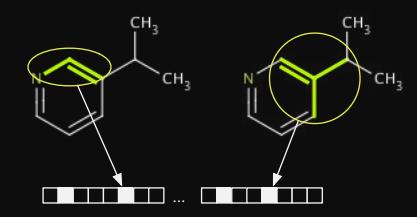

Details of RDKit Fingerprinting: https://rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf

There are many different methods for doing the same. For now we stick with RDKit Fingerprints. Fingerprints attempt to characterize local features and subgraphs.

Matching subgraphs, a.k.a. subgraph isomorphism, is an NP-complete problem.

## RDKit Fingerprint Algorithm

* Substructure fingerprint
* Atom types: set by atomic number and aromaticity
* Bond types: set by atom types and bond types

Algorithm:
For each subgraph (or path, if `branchedPaths` is false) of length `minPath - maxPath` bonds:
1. Generate hash for the path using bond types and each bond’s neighbor count
2. seed random-number generator with hash
3. generate `nBitsPerHash` random numbers between 0 and fpSize and set the corresponding bits
4. [optional]: “fold” fingerprint to target density of `tgtDensity` of bits set (minimum size `minSize` bits)

In [ ]:
mol = Chem.MolFromSmiles("C(C)(C)NC(=O)NO")
fingerprint = Chem.RDKFingerprint(mol)

print("Number of Bits:", fingerprint.GetNumBits())
print("Number of On Bits:", fingerprint.GetNumOnBits())

array = np.array([float(digit) for digit in fingerprint.ToBitString()])
print("Full Bit String:", array)


Number of Bits: 2048
Number of On Bits: 63
Full Bit String: [0. 0. 0. ... 0. 0. 1.]


## Fingerprints for predicting Solvation Energy

In [ ]:
df = pd.read_csv("freesolv_database.csv", sep=';')

Now for each of the molecules we need to compute molecular features, which are the fingerprints. We do it and stack them up to make our inputs matrix.

In [ ]:
def featurize(smiles):
    molecule = rdkit.Chem.MolFromSmiles(smiles)
    fingerprint = rdkit.Chem.RDKFingerprint(molecule)
    x = np.array(
        [float(digit) for digit in fingerprint.ToBitString()],
        dtype=np.float32,
    )
    return x


x = np.stack(df['SMILES'].apply(featurize).values)
y = df['experimental value (kcal/mol)'].values

We perform linear regression on this feature matrix.

In [ ]:
model = sklearn.linear_model.LinearRegression()

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2
)
model.fit(x_train, y_train)


LinearRegression()

In [ ]:
print("Error in Train Data:", 
      np.mean(np.square(y_train - model.predict(x_train))))
print("Variance in the Train Data:", np.var(y_train))

print("Error in Test Data:", 
      np.mean(np.square(y_test - model.predict(x_test))))
print("Variance in the Test Data:", np.var(y_test))

Error in Train Data: 0.012387013358824677
Variance in the Train Data: 14.872040038456298
Error in Test Data: 10020.747827395908
Variance in the Test Data: 14.358721579232016


## Extended Connectivity Fingerprints

1. Compute a unique index for each atom. This is a long integer hash made using the following features (Daylight atomic invariants)

* Number of non-hydrogen immediate neighbors
* Valency minus the number of connected hydrogens (i.e., total bond order ignoring H)
* Atomic number
* Atomic mass
* Atomic charge
* Number of attached hydrogens (both implicit and explicit)

2. Aggregate information from neighboring atoms and bonds connecting to them and use it to compute new feature vector.

    `[bond-order-1, atom-1-hash, bond-order-1, atom-2-hash, ...]`

    We hash this list to generate the 1-st iteration features for the atoms. These features in the 1-st iteration grab information from radius 1, diameter 2. We repeat this proecss, the 2-nd iteration vector will have information from radius 2, diameter 4.

    We do this for 2-3 iterations, leading to the different ECFP types, **ECFP-4, ECFP-6**, etc., depending on the diameter of data aggregation. 
    
    We also keep track of which bonds and atoms are getting aggregated in each iteration, and we de-duplicate the same neighborhood being added as a feature from two different starting points.

3. Given a target vector size, say 2048, take all the computed hashes over all iterations and find their values in this mod-field. i.e. `feature-id = hash-index % 2048`.

    Marks these feature ids in a 2048 length bit-vector, which now represents a hashed list of unique atom features, and substructure features upto small radii.

The following features are important to note about ECFP:
* The Hydrogen atoms are not a part of the fingerprinting process.
* ECFP depends on the hash function implementation of each programming language and therefore may differ in value from implementation to implementation.
* ECFP-4 is sufficient for most clustering or similarity indexing tasks.
* ECFP-6 or ECFP-8 might be needed for activity prediction tasks.


Refer to https://chemicbook.com/2021/03/25/a-beginners-guide-for-understanding-extended-connectivity-fingerprints.html for a detailed explainiation.

In [ ]:
molecule = rdkit.Chem.MolFromSmiles("C1CCCC1")

fingerprint = AllChem.GetMorganFingerprintAsBitVect(
                                                    molecule,
                                                    radius=3,
                                                    nBits=32
    )
fingerprint = np.asarray(fingerprint)

print("Morgan Fingerprint of Benzene", fingerprint)

Morgan Fingerprint of Benzene [0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]


## Molecule Similarity

$$\text{Travsky}_{a,b}(V_i, V_j) = \frac{V_i \cdot V_j}{a ||V_i||_1 + b ||V_j||_1 + (1 - a- b) V_i \cdot V_j}$$

Travsky similarity is the general framework in which all other fingerprint similarity measures fit.

$$\text{Tanimoto}(V_i, V_j) = \text{Travsky}_{1,1}(V_i, V_j)$$

Tanimoto similarity is the ratio of the number of molecular features present in both molecules (intersection) over the number of molecular features present in either molecule (union).

$$\text{Tanimoto}(V_i, V_j) = \frac{V_i \cdot V_j}{||V_i||_1 + ||V_j||_1 - V_i \cdot V_j}$$

$$\text{Dice}(V_i, V_j) = \text{Travsky}_{0.5,0.5}(V_i, V_j)$$

Tanimoto similarity is the ratio of the number of molecular features present in both molecules (intersection) over the average number of molecular features present in both the molecules (mean of L1 norm).

$$\text{Dice}(V_i, V_j) = \frac{V_i \cdot V_j}{\frac{1}{2} ||V_i||_1 + \frac{1}{2} ||V_j||_1}$$

In [ ]:
def generate_molecule_data(batch_size=128):
    smiles, data = [], []
    with open("gdb11_size08.smi", "r") as f:
        for dataline in tqdm.tqdm(list(f.readlines())):
            smile = dataline.split()[0]
            molecule = rdkit.Chem.MolFromSmiles(smile)
            fingerprint = rdkit.Chem.RDKFingerprint(molecule)
            data.append(fingerprint)
            smiles.append(smile)
    return data, smiles

fingerprints, smiles = generate_molecule_data()

  0%|          | 0/66706 [00:00<?, ?it/s]

In [ ]:
molecule_idx = np.random.randint(len(smiles))

similarities = [
    rdkit.DataStructs.FingerprintSimilarity(
        fingerprints[molecule_idx],
        fingerprint
    )
    for fingerprint in fingerprints
]

indexes = np.argsort(similarities)[::-1]

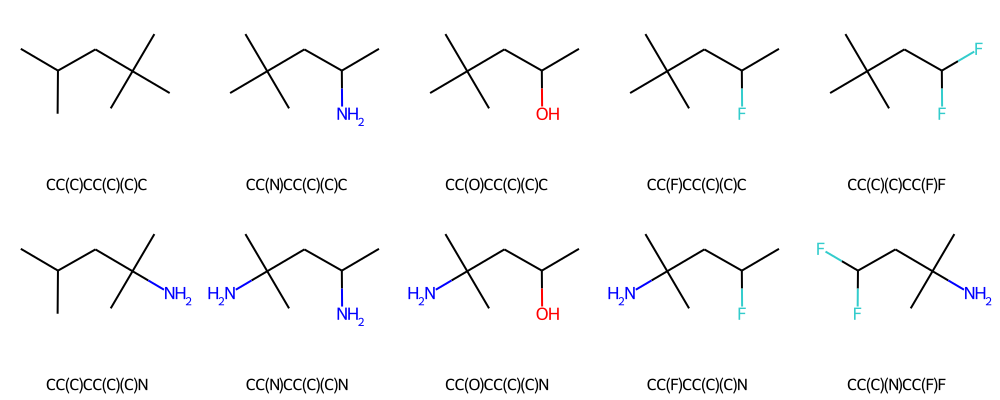

In [ ]:
img = rdkit.Chem.Draw.MolsToGridImage(
    [rdkit.Chem.MolFromSmiles(smile) for smile in smiles[:10]],
    molsPerRow=5,
    legends=smiles[:10]
)
display(img)

## Exercise: Predict Log-p values

In [ ]:
import rdkit.Chem.Crippen

log_p = np.array([
    rdkit.Chem.Crippen.MolLogP(rdkit.Chem.MolFromSmiles(smile))
    for smile in tqdm.tqdm(smiles)
], dtype=np.float32)

  0%|          | 0/66706 [00:00<?, ?it/s]

Now you are given the list of all smiles and the list of all log-p values for those smiles. Use RDKit fingerprints and Morgan fingerprints (if it's hard to get these, see the code in the next segment) along with any other fingerprint methods of your choice, and evaluate which perform best as input to a linear regressor.

In [ ]:
fingerprint_array = np.array([
    list(map(float, fingerprint.ToBitString()))
    for fingerprint in tqdm.tqdm(fingerprints)
], dtype=np.float32)

  0%|          | 0/66706 [00:00<?, ?it/s]

In [ ]:
fingerprint_array.shape, log_p.shape

((66706, 2048), (66706,))

In [ ]:
model = sklearn.linear_model.LinearRegression()

fingerprint_array_train, fingerprint_array_test, log_p_train, log_p_test = \
    sklearn.model_selection.train_test_split(
        fingerprint_array, log_p, test_size=0.2)

model.fit(fingerprint_array_train, log_p_train)

print("Error in Test Data:",
      np.mean(np.square(log_p_train - model.predict(fingerprint_array_train))))
print("Variance in the Test Data:", np.var(log_p_train))

print("Error in Test Data:",
      np.mean(np.square(log_p_test - model.predict(fingerprint_array_test))))
print("Variance in the Test Data:", np.var(log_p_test))

RMS error in Test Data: 0.0870132
Variance in the Test Data: 0.97314316
RMS error in Test Data: 0.09640389
Variance in the Test Data: 0.9718189


Now we use Morgan Fingerprints for the same classification.

In [ ]:
morgan_fingerprint_array = np.stack([
    np.asarray(
        rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(
            rdkit.Chem.MolFromSmiles(smile),
            radius=3,
            nBits=128
        )
    )
    for smile in tqdm.tqdm(smiles)
])

  0%|          | 0/66706 [00:00<?, ?it/s]

In [ ]:
model = sklearn.linear_model.LinearRegression()

fingerprint_array_train, fingerprint_array_test, log_p_train, log_p_test = \
    sklearn.model_selection.train_test_split(
        morgan_fingerprint_array, log_p, test_size=0.2)

model.fit(fingerprint_array_train, log_p_train)

print("Error in Test Data:",
      np.mean(np.square(log_p_train - model.predict(fingerprint_array_train))))
print("Variance in the Test Data:", np.var(log_p_train))

print("Error in Test Data:",
      np.mean(np.square(log_p_test - model.predict(fingerprint_array_test))))
print("Variance in the Test Data:", np.var(log_p_test))

Error in Test Data: 0.4361878013842864
Variance in the Test Data: 0.97125566
Error in Test Data: 0.43536483536995885
Variance in the Test Data: 0.9793462


**Exploratory Task:**
Play around with the number of bits and radius of features in the Morgan Fingerprint, and compare it to other fingerprint methods, both for learning and finding similar elements. Also compare the different similarity measures for clustering tasks. See Topological-Torsion fingerprints and other methods.

**Exploratory Task:**
Lookup the ChEMBL dataset for Log-p values (drug likeness), and the Tox21 dataset for the toxicity value of molecules (the input already has in the sparse features file a list of ECFP fingerprints). Run classification/regression algorithms on these using the techniques learnt above. Attempt to characterize which tasks will these fingerprint based methods work well on and provide intuitive explainations for the same.

# End of tutorial